In [1]:
import sympy as sy
sy.init_printing(use_latex=True)
import numpy as np
import pandas as pd
import scipy as sc
import scipy.linalg as LA
import matplotlib.pyplot as plt
import math
import vpython as vp
import scipy.integrate as integrate
import copy
vec = vp.vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Abgabe aus dem Fach Modellbildung und Simulation - Klassische Mechanik 2

## Keplerproblem

Zwei Massen $M$ und $m$, die den Abstand $r$ zueinander besitzen, ziehen sich gegenseitig mit der Kraft
$$ \vec{F}_G = -G\frac{Mm}{r^2}\vec{e}_r $$
an. $G$ ist die universelle Gravitationskonstante.

In [2]:
x = sy.symbols('x')

### 1.
Im File Sat.txt sind die Umlaufzeiten $T$ und mittleren Radien $r$ der Umlaufbahnen von vier Satelliten angegeben (die einen Asteroiden umkreisen). Zeigen Sie, dass sich die Datein mit der Form $T=Cr^n$ beschreiben lassen. Bestimmen Sie $n$ und $C$, indem sie Sie die Daten logarithmisch auftragen. Schätzen Sie den fehlenden Radius ab.

Aufgabe herausfinden was C und n sein können.

Die Umlaufzeit ist gegeben durch $a= \omega^2r = (\frac{2\pi}{T})^2r$

['T in a ', 'r in Gm ']
[['T in a ', 'r in Gm '], ['0.44', '0.088'], ['1.61', '0.208'], ['3.88', '0.374'], ['6.20', '?'], ['7.89', '0.600']]
{'T in a ': [0.44, 1.61, 3.88, 6.2, 7.89], 'r in Gm ': [0.088, 0.208, 0.374, x, 0.6]}
[0.44, 1.61, 3.88, 7.89]
[0.088, 0.208, 0.374, 0.6]


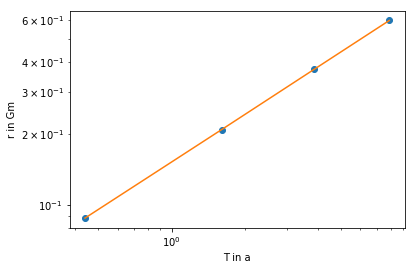

In [3]:
with open("Sat.txt", "r") as f:
    sat = [line.split() for line in f]
header_ = sat[0]
header = []
h_str1 = ''
h_str2 = ''
for i in range(0, 3):
    h_str1 += header_[i] + ' '
    h_str2 += header_[i+3] + ' '
header = [h_str1, h_str2]
sat[0] = header
print(header)
print(sat)
sat_data = {}
for s in range(1, len(sat)):
    for n in range(0, len(sat[s])):
        if sat[s][n] == '?':
            sat[s][n] = x
        else:
            sat[s][n] = float(sat[s][n])
sat_data = {sat[0][i]: [ line[i] for line in sat[1:] ]  for i in range(len(sat[0]))}
print(sat_data)
xs = sat_data['T in a '][0:3]
xs.append(sat_data['T in a '][4])
print(xs)

ys = sat_data['r in Gm '][0:3]
ys.append(sat_data['r in Gm '][4])
print(ys)
plt.loglog(xs, ys, 'o')
plt.loglog(xs, ys)
plt.xlabel('T in a')
plt.ylabel('r in Gm')
plt.show()

$\mathrm{ln}(a) + b \mathrm{ln}(x) = \mathrm{ln}(y) $
Berechnung Potenzfunktion : $y = ax^b$

### 2.
Schreiben Sie ein Programm, das die Differentialgleichung
$$ m\ddot{\vec{r}} = -G\frac{Mm}{r^3}\vec{r} $$
löst und visualisieren Sie die Bahnkurve der Erde um die Sonne. Verwenden sie als Anfangsgeschwindigkeit $(0.0, 29.8)*10^3m/s$ und den Anfangsort der Erde $(1.4960, 0.0)*10^{11}m$ (Die Sonne ruhe anfänglich im Urspung). Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung numerisch.

In [5]:
M, m, r, G, vr, t = sy.symbols('M, m, r, G, \\vec{r}, t')
ddr = sy.symbols('\ddot{\\vec{r}}', function=True)

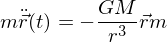

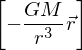

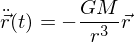

In [6]:
gl = sy.Eq(m*ddr(t), -G*((M*m)/r**3)*vr)
display(gl)
gl = sy.solve(gl, ddr(t))
display(gl)
gl2 = sy.Eq(ddr(t), gl[0])
display(gl2)

In [7]:
def rk4(y, t, m, h, ode):
    k1 = np.array(ode(t, y, m))
    k2 = np.array(ode(t+(h/2), y+ (h/2)*k1, m))
    k3 = np.array(ode(t+(h/2), y+(h/2)*k2, m))
    k4 = np.array(ode(t+h, y+h*k3, m))
    ynew = y + h*(k1+2*k2+2*k3+k4)/6
    return ynew

In [8]:
#def ODEBahngleichung(t, y):
def ODEBahngleichung(y, t):
    #print('Bahngleichung')
    #print('t', t)
    #print('y', y)
    rx = y[0]
    ry = y[1]
    dy = np.zeros_like(y)
    dy[0] = y[-2]
    dy[1] = y[-1]
    #dy[2] = -(G_val*M_val*rx)/(sy.sqrt(rx**2+ry**2)**3)
    #dy[3] = -(G_val*M_val*ry)/(sy.sqrt(rx**2+ry**2)**3)
    GM = G_val*M_val
    #print('rx', rx)
    #print('GM', GM)
    #print('|r|', sy.sqrt(rx**2+ry**2))
    dy[2] = -((G_val*M_val)*rx)/(sy.sqrt(rx**2+ry**2)**3)
    dy[3] = -((G_val*M_val)*ry)/(sy.sqrt(rx**2+ry**2)**3)
    #print('old r_n', y)
    #print('dr_n', dy)
    return dy

In [9]:
def ODEBahngleichung_rk(t, y, m):
#def ODEBahngleichung(y, t):
    #print('Bahngleichung')
    #print('t', t)
    #print('y', y)
    rx = y[0]
    ry = y[1]
    dy = np.zeros_like(y)
    dy[0] = y[-2]
    dy[1] = y[-1]
    #dy[2] = -(G_val*M_val*rx)/(sy.sqrt(rx**2+ry**2)**3)
    #dy[3] = -(G_val*M_val*ry)/(sy.sqrt(rx**2+ry**2)**3)
    dy[2] = -((G_val*m)*rx)/(sy.sqrt(rx**2+ry**2)**3)
    dy[3] = -((G_val*m)*ry)/(sy.sqrt(rx**2+ry**2)**3)
    #print('old r_n', y)
    #print('dr_n', dy)
    return dy

In [10]:
def euler(y, t, h, ode):
    ynew = y+h*np.array(ode(t,y))
    return ynew

In [11]:
def abl(f, xold, xnew):
    t = 0
    diff_matr = np.zeros(shape=(len(xold),len(xold)))
    for i in range(0, len(xold)):
        xzw = copy.deepcopy(xold)
        xer = xnew[i]
        xzw[i] = xer
        fold = np.array(f(t, xold))
        fzw = np.array(f(t, xzw))
        dif_q = np.array((fold-fzw)/(xold[i]-xnew[i]))
        dif_q = list(dif_q)
        for j in range(0, len(dif_q)):
            #print(dif_q[j])
            diff_matr[i][j] = dif_q[j]
    return diff_matr

In [12]:
def impeuler(y, t, h, ode):
    y_np1 = euler(y, t, h, ode)
    abl_m = abl(ode, y, y_np1)
    J = np.array(np.eye(len(y)))-(h*abl_m)
    J = J.T
    LU, P = LA.lu_factor(J)
    for i in range(1,3):
        b1 = (h*np.array(ode(t+h, y_np1)))
        b2 = (y+(-1)*h*np.array(ode(t+h, y_np1)))
        b = (-1*(y_np1-y-b1))
        y_del = LA.lu_solve((LU, P), b)
        y_np1 = y_np1 + y_del
    ynew = y_np1
    return ynew

In [742]:
#Grafik
M_val = m_s
G_val = 6.674031e-11
def Bahnkurve_Plot(anfangsort, anfangsgesch, t0, tend, N=1000):
    vr_val = anfangsort-a_ort_sonne
    print('abstand', vr_val)
    r_val = LA.norm(vr_val)
    print('abstand norm ', r_val)
    #C1_val = anfangsgesch + G_val*(M_val*r_val)/(LA.norm(r_val)**3)*t0
    #ddr_t = (-(G_val*M_val*np.array([rx1, ry1]))/(sy.sqrt(rx1**2+ry1**2)**3))
    print('GM', G_val*M_val)
    #display(ddr_n)
    #dr_n = anfangsgesch
    #ddr_n = ddr(t0, dr_n, vr_val)
    r_n = np.array([vr_val[0], vr_val[1], anfangsgesch[0], anfangsgesch[1]])
    dr_n = ODEBahngleichung_rk(t0, r_n)
    #dr_n = ODEBahngleichung(r_n, t0)
    xs = [r_n[0]]
    ys = [r_n[1]]
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    print('h', h)
    gesch = [r_n[2], r_n[3]]
    ort = [r_n[0], r_n[1]]
    alpha = np.arccos(np.dot(gesch, ort)/(LA.norm(gesch)*LA.norm(ort)))
    I = m_erde*LA.norm(gesch)
    Is = [I]
    L = m_erde*LA.norm(gesch)*LA.norm(ort)*math.sin(alpha)
    LS = [L]
    plt.plot(anfangsort[0], anfangsort[1], 'ob', label='Anfangsort Erde', ms=4)
    plt.plot(a_ort_sonne[0], a_ort_sonne[1], 'oy', label='Anfangsort Sonne', ms=10)
    for ts in tvals:
        #ddr_np1 = np.array([0., 0.])
        #print('ddr_t', ddr_t[1].subs(rx1, r_n[0]).subs(ry1, r_n[1]))
        #print('dr_n', dr_n)
        #print('r_n', r_n)
        #ddr_np1 = ddr(t, dr_n, r_n)
        #display(ddr_np1)
        #dr_np1 = rk4(r_n, dr_n, t, h, ddr)
        #r_np1 = rk4(r_n, r_n, t, h, dr)
        #print('r_np1', r_np1)
        r_np1 = rk4(r_n, ts, h, ODEBahngleichung_rk)
        gesch = [r_n[2], r_n[3]]
        ort = [r_n[0], r_n[1]]
        alpha = np.arccos(np.dot(gesch, ort)/(LA.norm(gesch)*LA.norm(ort)))
        L = m_erde*LA.norm(gesch)*LA.norm(ort)*math.sin(alpha)
        #assert np.allclose(L, LS[-1])
        LS.append(L)
        I = m_erde*LA.norm(gesch)
        Is.append(I)
        #assert np.allclose(I, Is[-1])
        
        xs.append(r_np1[0])
        ys.append(r_np1[1])
        
        #ddr_n = ddr_np1
        #dr_n = dr_np1
        r_n = r_np1
    #print(xs)
    #print(ys)
    #sol = integrate.odeint(ODEBahngleichung, r_n, tvals)
    #print(sol)
    #print(sol[1])
    #xs = [s[0] for s in sol]
    #ys = [s[1] for s in sol]
    #print('maximal y', max(ys))
    #print('minimal y', min(ys))
    #print((max(ys)-min(ys))/2)
    #print((max(xs)-min(xs))/2)
    #x_list = np.arange(min(xs), max(xs), 1e10)
    #print([min(ys)+(max(ys)-min(ys)/2)]*len(x_list))
    #plt.plot(x_list, [min(ys)+((max(ys)-min(ys))/2)]*len(x_list), '--r')
    #y_list = np.arange(min(ys), max(ys), 1e10)
    #print([min(ys)+(max(ys)-min(ys)/2)]*len(x_list))
    #x_list = [min(xs)+((max(xs)-min(xs))/2)]*len(y_list)
    #plt.plot(x_list, y_list, '--g')
    #print([min(xs)+((max(xs)-min(xs))/2)]*len(y_list))
    #print(xs)
    plt.plot(xs, ys, 'b', label='Bahnkurve Erde')
    plt.plot(xs[-1], ys[-1], 'ob', label='Endort Erde', mec='#000000')
    plt.legend()
    #plt.axis([-2.5e11, 2.5e11, -2.5e11, 2.5e11])
    plt.axis('scaled')
    plt.show()
    return LS, Is

In [743]:
#Grafik
#M_val = m_sonne
"""
G_val = 6.674031e-11
def Bahnkurve_Plot(anfangsorte, anfangsgesch, massen, t0, tend, N=1000):
    a_ort_e = anfangsorte[0]
    a_ort_s = anfangsorte[1]
    a_gesch_e = anfangsgesch[0]
    a_gesch_s = anfangsgesch[1]
    vr_val = a_ort_e-a_ort_s
    print('abstand', vr_val)
    r_val = LA.norm(vr_val)
    print('abstand norm ', r_val)
    #C1_val = anfangsgesch + G_val*(M_val*r_val)/(LA.norm(r_val)**3)*t0
    #ddr_t = (-(G_val*M_val*np.array([rx1, ry1]))/(sy.sqrt(rx1**2+ry1**2)**3))
    #display(ddr_n)
    #dr_n = anfangsgesch
    #ddr_n = ddr(t0, dr_n, vr_val)
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    LS = []
    IS = []
    farben = ['b', 'y']
    namen = ['Erde', 'Sonne']
    radien = [5, 10]
    for p in range(0, len(anfangsgesch)):
        Ls = []
        Is = []
        print(abs(p-1))
        M_val_that = massen[abs(p-1)]
        M_val_this = massen[p]
        rschw = ((M_val_that)/(M_val_this+M_val_that))*dist
        print('masse für for = ', p, '=', M_val_that)
        r_n = np.array([vr_val[0], vr_val[1], anfangsgesch[p][0], anfangsgesch[p][1]])
        dr_n = ODEBahngleichung_rk(t0, r_n, M_val_that)
        #dr_n = ODEBahngleichung(r_n, t0)
        
        xs = [r_n[0]]
        ys = [r_n[1]]
        #print('h', h)
        plt.plot(anfangsorte[p][0], anfangsorte[p][1], 'o'+farben[p], label='Anfangsort '+namen[p], ms=radien[p])
        
        gesch = [r_n[2], r_n[3]]
        ort = [r_n[0], r_n[1]]
        #if LA.norm(gesch) > 0 and ort > 0:
        #    alpha = np.arccos(np.dot(gesch, ort)/(LA.norm(gesch)*LA.norm(ort)))
        #    I = M_val_this*LA.norm(gesch)
        #    Is = [I]
        #    L = M_val_this*LA.norm(gesch)*LA.norm(ort)*math.sin(alpha)
        #    Ls = [L]
        
        for ts in tvals:
            #ddr_np1 = np.array([0., 0.])
            #print('ddr_t', ddr_t[1].subs(rx1, r_n[0]).subs(ry1, r_n[1]))
            #print('dr_n', dr_n)
            #print('r_n', r_n)
            #ddr_np1 = ddr(t, dr_n, r_n)
            #display(ddr_np1)
            #dr_np1 = rk4(r_n, dr_n, t, h, ddr)
            #r_np1 = rk4(r_n, r_n, t, h, dr)
            #print('r_np1', r_np1)
            r_np1 = rk4(r_n, ts, M_val_that, h, ODEBahngleichung_rk)
            gesch = [r_n[2], r_n[3]]
            ort = [r_n[0], r_n[1]]
            #alpha = np.arccos(np.dot(gesch, ort)/(LA.norm(gesch)*LA.norm(ort)))
            L = M_val_this*LA.norm(gesch)*LA.norm(ort)*math.sin(alpha)
            assert np.allclose(L, Ls[-1])
            Ls.append(L)
            #I = M_val_this*LA.norm(gesch)
            #Is.append(I)
            #assert np.allclose(I, Is[-1])

            xs.append(r_np1[0])
            ys.append(r_np1[1])

            #ddr_n = ddr_np1
            #dr_n = dr_np1
            r_n = r_np1
    #print(xs)
    #print(ys)
    #sol = integrate.odeint(ODEBahngleichung, r_n, tvals)
    #print(sol)
    #print(sol[1])
    #xs = [s[0] for s in sol]
    #ys = [s[1] for s in sol]
    #print('maximal y', max(ys))
    #print('minimal y', min(ys))
    #print((max(ys)-min(ys))/2)
    #print((max(xs)-min(xs))/2)
    #x_list = np.arange(min(xs), max(xs), 1e10)
    #print([min(ys)+(max(ys)-min(ys)/2)]*len(x_list))
    #plt.plot(x_list, [min(ys)+((max(ys)-min(ys))/2)]*len(x_list), '--r')
    #y_list = np.arange(min(ys), max(ys), 1e10)
    #print([min(ys)+(max(ys)-min(ys)/2)]*len(x_list))
    #x_list = [min(xs)+((max(xs)-min(xs))/2)]*len(y_list)
    #plt.plot(x_list, y_list, '--g')
    #print([min(xs)+((max(xs)-min(xs))/2)]*len(y_list))
    #print(xs)
        #IS.append(Is)
        LS.append(Ls)
        plt.plot(xs, ys, 'b', label='Bahnkurve Erde')
        plt.plot(xs[-1], ys[-1], 'ob', label='Endort Erde', mec='#000000')
    plt.legend()
    #plt.axis([-2.5e11, 2.5e11, -2.5e11, 2.5e11])
    plt.axis('scaled')
    plt.show()
        
    return LS, IS
"""

"\nG_val = 6.674031e-11\ndef Bahnkurve_Plot(anfangsorte, anfangsgesch, massen, t0, tend, N=1000):\n    a_ort_e = anfangsorte[0]\n    a_ort_s = anfangsorte[1]\n    a_gesch_e = anfangsgesch[0]\n    a_gesch_s = anfangsgesch[1]\n    vr_val = a_ort_e-a_ort_s\n    print('abstand', vr_val)\n    r_val = LA.norm(vr_val)\n    print('abstand norm ', r_val)\n    #C1_val = anfangsgesch + G_val*(M_val*r_val)/(LA.norm(r_val)**3)*t0\n    #ddr_t = (-(G_val*M_val*np.array([rx1, ry1]))/(sy.sqrt(rx1**2+ry1**2)**3))\n    #display(ddr_n)\n    #dr_n = anfangsgesch\n    #ddr_n = ddr(t0, dr_n, vr_val)\n    tvals, h = np.linspace(t0, tend, N, retstep=True)\n    LS = []\n    IS = []\n    farben = ['b', 'y']\n    namen = ['Erde', 'Sonne']\n    radien = [5, 10]\n    for p in range(0, len(anfangsgesch)):\n        Ls = []\n        Is = []\n        print(abs(p-1))\n        M_val_that = massen[abs(p-1)]\n        M_val_this = massen[p]\n        rschw = ((M_val_that)/(M_val_this+M_val_that))*dist\n        print('masse f

In [744]:
def ODEPlaneten_rk(t, y, massen):
    '''
    berechnet die rechte Seite der Differentialgleichung 
    Zunächst kommen alle Variablen (x,y,vx,vy) für den ersten Planeten, dann alle 4 für den zweiten,... 
    :param t: aktueller zeitpunkt
    :param y: aktueller y-Wert (n Komponenten)
    :return: rechte Seite f der Dgl. y'=f(t,y)
    '''

    # Daten der Planeten
    G = 6.674E-11 #Gravitationskonstante
    y = np.array(y)
    y = y.reshape(-1, 4)
    #print(y)
    rs = []
    dy = []
    #print(planets)
    for i in range(0, len(y)):
        F_i = np.array([0., 0.])
        rs.append(np.array([y[i][0], y[i][1]]))
        r_i = np.array([y[i][0], y[i][1]])
        for j in range(0, len(y)):
            if i != j:
                r_j = np.array([y[j][0], y[j][1]])
                m_j = massen[j]
                dist = r_i-r_j
                if LA.norm(dist) > 0:
                    F_i += m_j *((dist)/(LA.norm(dist))**3)
                else:
                    F_i += np.array([0., 0.])
        #f i == 1:
        #   print('F_i', F_i)
        ddr_i = -G*F_i
        dy.append(y[i][2])
        dy.append(y[i][3])
        dy.append(ddr_i[0])
        dy.append(ddr_i[1])
    return dy

In [745]:
def integrateall(method, ode, massen, y0, t0, tend, N, intermediate=False):
    """
    :param method: Enschrittverfahren
    :param ode: Rechte seite der Dgl
    :param y0: Anfangswert
    :param t0: Anfangszeitpunkt
    :param tend: Endzeitpunkt
    :param N: Anzahl der Schritte
    :param intermediate: True, wenn zum Plotten der Lösung auch die Ergebnisse der Zwischenschritte zurückgegeben werden sollen
    :return: Lösung am Endzeitpunkt (bzw. zusätzlich an den Zwischenzetpunkten, wenn intermediate =True)
    """
    yvals = [y0]
    print('integrateall', yvals)
    space =  np.linspace(t0, round(tend, 5), num=N, retstep=True, dtype=float)
    tvals = space[0]
    h = space[1]
    y = y0
    for ts in tvals:
        y = method(y, ts, massen, h, ode)
        yvals.append(y)
    del yvals[-1]
    yend=yvals[-1]
    if intermediate:
        return np.array(yvals), tvals
    else:
        return yend

In [746]:
def Planeten_Coordinates(Planeten, t0, tend, N):
    Planet_n = []
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    #print(h)
    coordinates = {}
    y_planeten = []
    massen = []
    for planet in Planeten:
        print(planet)
        Planet_n.append(planet)
        x_s = Planeten[planet]['pos'][0]
        y_s = Planeten[planet]['pos'][1]
        dx_s = Planeten[planet]['gesch'][0]
        dy_s = Planeten[planet]['gesch'][1]
        y_planeten.append(x_s)
        y_planeten.append(y_s)
        y_planeten.append(dx_s)
        y_planeten.append(dy_s)
        massen.append(Planeten[planet]['masse'])
        coordinates[planet] = {'x':[], 'y':[]}
    #y_list = [y_sterne]
    print('y planeten', y_planeten)
    y_list, t_list = integrateall(rk4, ODEPlaneten_rk, massen, y_planeten, t0, tend, N, intermediate=True)
    #print(y_list)
    #y_list[0] = np.array(y_list[0])
    #print(y_list)
    for y_step in y_list:
        y_shaped = y_step.reshape(-1, 4)
        #print('y shaped', y_shaped)
        for i in range(0, len(y_shaped)):
            list_c = coordinates[Planet_n[i]]['x']
            #print(y_shaped[i][0])
            list_c.append(y_shaped[i][0])
            list_c = coordinates[Planet_n[i]]['y']
            list_c.append(y_shaped[i][1])
    
    return coordinates

In [767]:
def Planets_Plot(Namen, AOrte, AGesch, Massen, Zeiten, Schritte):
    Planeten = {}
    print(len(AOrte))
    print(Namen)
    print(AOrte)
    print(AGesch)
    print(Massen)
    print(Zeiten)
    print(Schritte)
    for i in range(0, len(AOrte)):
        print(i)
        Planeten[Namen[i]] = {'pos' : AOrte[i], 'gesch': AGesch[i], 'masse': Massen[i]}
    print(Planeten)
    t0 = Zeiten[0]
    tend = Zeiten[1]
    N = Schritte
    coordinates = Planeten_Coordinates(Planeten, t0, tend, N)
    #print(coordinates)
    for st in coordinates:
        r = np.random.rand()
        g = np.random.rand()
        b = np.random.rand()
        xs = coordinates[st]['x']
        ys = coordinates[st]['y']
        plt.plot(xs[0], ys[0], 'x', color=[r, g, b], label='Anfangspunkt'+st)
        plt.plot(xs, ys, color=[r, g, b], label=st)
        plt.plot(xs[-1], ys[-1], 'o', color=[r, g, b], label='Endpunkt'+st)

    plt.legend()
    #plt.axis('scaled')
    #plt.show()
    return coordinates

In [768]:
r1 = sy.symbols('\\vec{r}_1')
rx1 = sy.symbols('r_{x_1}')
ry1 = sy.symbols('r_{y_1}')
m_e = 5.974E24
print(m_e)
m_s = 1.989E30
#a_ort_e = np.array([1.4960e11, 0.])
a_ort_e = np.array([149.6E6*10e3, 0.0])
a_ort_s = np.array([0, 0.])
#a_gesch_e = np.array([0., 29.8e3])
a_gesch_e = np.array([0.0, -29.78]) 
a_gesch_s = np.array([0., 0.])
#G_val = 6.673E-20
#print(G_val*m_s)
print(4*np.pi*np.pi)

#a_gesch_e = np.array([0., 40e2])

5.974e+24
39.47841760435743


In [769]:
#m_e = 5.972e24
m_e = 5.972e24
print(m_e)
#m_s = 1.989e30
m_s = 1.989e30
a_ort_e = np.array([149.6e11, 0.])
#a_ort_e = np.array([149.6e6, 0.0])
a_ort_s = np.array([0, 0.])
#a_gesch_e = np.array([0., 29.8e3])
#a_gesch_e = np.array([0.0, -29.78]) 
#a_gesch_e = np.array([0.0, 29.8e3])
a_gesch_e = np.array([0.0, 2.978e3])

a_gesch_s = np.array([0., 0.])
#print(np.sqrt((6.674E-11*m_s)/a_ort_e))
#G_val = 6.673E-22
#print(G_val*m_s)
#print(4*np.pi*np.pi)

#a_gesch_e = np.array([0., 40e2])

5.972e+24


2
['Sonne', 'Erde']
[array([0., 0.]), array([1.496e+13, 0.000e+00])]
[array([0., 0.]), array([   0., 2978.])]
[1.989e+30, 5.972e+24]
[0, 31540000000.0]
10000
0
1
{'Sonne': {'pos': array([0., 0.]), 'gesch': array([0., 0.]), 'masse': 1.989e+30}, 'Erde': {'pos': array([1.496e+13, 0.000e+00]), 'gesch': array([   0., 2978.]), 'masse': 5.972e+24}}
Sonne
Erde
y planeten [0.0, 0.0, 0.0, 0.0, 14960000000000.0, 0.0, 0.0, 2978.0]
integrateall [[0.0, 0.0, 0.0, 0.0, 14960000000000.0, 0.0, 0.0, 2978.0]]
[0.0, 8.859782197238836, 35.43912529967024, 79.73801883944036, 141.75644537013068, 221.49438046676477, 318.95179272581777, 434.12864376522884, 567.0248882244159, 717.6404737642933]
[14960000000000.0, 14959997049211.857, 14959988196848.59, 14959973442913.686, 14959952787412.953, 14959926230354.53, 14959893771748.873, 14959855411608.766, 14959811149949.316, 14959760986787.957]


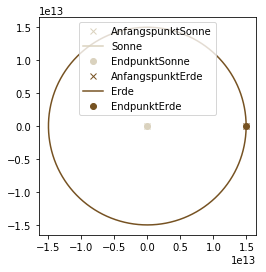

In [771]:
Namen = ['Sonne', 'Erde']
Orte = [a_ort_s, a_ort_e]
Gesch = [a_gesch_s, a_gesch_e]
Massen = [m_s, m_e]
c = Planets_Plot(Namen, Orte, Gesch, Massen, [0, 3.154e10], 10000)
plt.axis('scaled')
print(c['Sonne']['x'][0:10])
print(c['Erde']['x'][0:10])

In [772]:
#m_e = 5.972e24
m_e = 5.972e24
print(m_e)
#m_s = 1.989e30
m_s = 1.989e30
a_ort_e = np.array([149.6e11, 0.])
#a_ort_e = np.array([149.6e6, 0.0])
a_ort_s = np.array([0, 0.])
#a_gesch_e = np.array([0., 29.8e3])
#a_gesch_e = np.array([0.0, -29.78]) 
#a_gesch_e = np.array([0.0, 29.8e3])
a_gesch_e = np.array([0.0, 29.78e3])

a_gesch_s = np.array([0., 0.])
#print(np.sqrt((6.674E-11*m_s)/a_ort_e))
#G_val = 6.673E-22
#print(G_val*m_s)
#print(4*np.pi*np.pi)

#a_gesch_e = np.array([0., 40e2])

5.972e+24


2
['Sonne', 'Erde']
[array([0., 0.]), array([1.496e+13, 0.000e+00])]
[array([0., 0.]), array([    0., 29780.])]
[1.989e+30, 5.972e+24]
[0, 9000000000.0]
10000
0
1
{'Sonne': {'pos': array([0., 0.]), 'gesch': array([0., 0.]), 'masse': 1.989e+30}, 'Erde': {'pos': array([1.496e+13, 0.000e+00]), 'gesch': array([    0., 29780.]), 'masse': 5.972e+24}}
Sonne
Erde
y planeten [0.0, 0.0, 0.0, 0.0, 14960000000000.0, 0.0, 0.0, 29780.0]
integrateall [[0.0, 0.0, 0.0, 0.0, 14960000000000.0, 0.0, 0.0, 29780.0]]
[0.0, 0.7214136485131012, 2.8856476923859202, 6.492681426948671, 11.542480345517301, 18.034996141041745, 25.970166708413213, 35.34791614743029, 46.16815476642347, 58.430779086537754]
[14960000000000.0, 14959999759730.115, 14959999038922.762, 14959997837584.836, 14959996155727.828, 14959993993367.828, 14959991350525.521, 14959988227226.186, 14959984623499.693, 14959980539380.508]


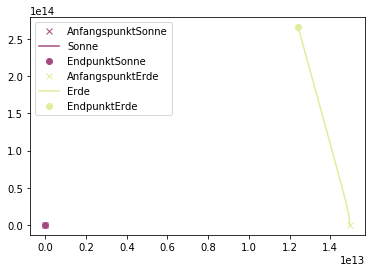

In [774]:
Namen = ['Sonne', 'Erde']
Orte = [a_ort_s, a_ort_e]
Gesch = [a_gesch_s, a_gesch_e]
Massen = [m_s, m_e]
c = Planets_Plot(Namen, Orte, Gesch, Massen, [0, 9e9], 10000)
print(c['Sonne']['x'][0:10])
print(c['Erde']['x'][0:10])

In [381]:
""""
L,I = Bahnkurve_Plot([a_ort_e, a_ort_s], [a_gesch_e, a_gesch_s], [m_e, m_s], 0, 31554030.44102971, N=100)
print(m_e)
print(m_s)
print(L)
#plt.plot(L, [1.]*len(L))
#plt.show()
#plt.plot(I, [1.]*len(I))
#plt.show()
#print(I)
"""

'"\nL,I = Bahnkurve_Plot([a_ort_e, a_ort_s], [a_gesch_e, a_gesch_s], [m_e, m_s], 0, 31554030.44102971, N=100)\nprint(m_e)\nprint(m_s)\nprint(L)\n#plt.plot(L, [1.]*len(L))\n#plt.show()\n#plt.plot(I, [1.]*len(I))\n#plt.show()\n#print(I)\n'

In [33]:
"""p = m_erde*LA.norm(a_gesch_e)
print(p)
alpha = np.arccos(np.dot(a_gesch_e, a_ort_e)/(LA.norm(a_gesch_e)*LA.norm(a_ort_e)))
print(alpha*180/math.pi)
L = m_erde*LA.norm(a_gesch_e)*LA.norm(a_ort_e)*math.sin(alpha)
print('L', L)
print(math.sin(alpha))
T = (4*math.pi**2)/(G_val*m_s)*LA.norm(a_ort_e)**3
T = np.sqrt(T)
print('T', T)
E_kin = 0.5*m_erde*LA.norm(a_gesch_e)**2 
#+ L**2/(2*m_erde*LA.norm(a_ort_e)**2)
E_pot = -G_val*(m_e*m_s)/LA.norm(a_ort_e)
print('E_kin', E_kin)
print('E_pot', E_pot)
E_0 = E_kin+E_pot
print('E_0', E_0)
E_test = 0.5*m_e*LA.norm(a_gesch_e)**2-(alpha/LA.norm(a_ort_e))
print('L', L)
print('E_test', E_test)
a = ((2*math.pi)/T)**2*LA.norm(a_ort_e)
E_test = 0.5*m_e*LA.norm(a_gesch_e)**2-(a/LA.norm(a_ort_e))
print(a)
print('E_test 2:', E_test)
E_circle = (-m_erde*LA.norm(a_ort_e))/(2*L**2)
print('E_circle', E_circle)
print('Impulserhaltung')
I = (sum([m_e*LA.norm(a_gesch_e), m_s*LA.norm([0,0])]))
print(I)"""

"p = m_erde*LA.norm(a_gesch_e)\nprint(p)\nalpha = np.arccos(np.dot(a_gesch_e, a_ort_e)/(LA.norm(a_gesch_e)*LA.norm(a_ort_e)))\nprint(alpha*180/math.pi)\nL = m_erde*LA.norm(a_gesch_e)*LA.norm(a_ort_e)*math.sin(alpha)\nprint('L', L)\nprint(math.sin(alpha))\nT = (4*math.pi**2)/(G_val*m_s)*LA.norm(a_ort_e)**3\nT = np.sqrt(T)\nprint('T', T)\nE_kin = 0.5*m_erde*LA.norm(a_gesch_e)**2 \n#+ L**2/(2*m_erde*LA.norm(a_ort_e)**2)\nE_pot = -G_val*(m_e*m_s)/LA.norm(a_ort_e)\nprint('E_kin', E_kin)\nprint('E_pot', E_pot)\nE_0 = E_kin+E_pot\nprint('E_0', E_0)\nE_test = 0.5*m_e*LA.norm(a_gesch_e)**2-(alpha/LA.norm(a_ort_e))\nprint('L', L)\nprint('E_test', E_test)\na = ((2*math.pi)/T)**2*LA.norm(a_ort_e)\nE_test = 0.5*m_e*LA.norm(a_gesch_e)**2-(a/LA.norm(a_ort_e))\nprint(a)\nprint('E_test 2:', E_test)\nE_circle = (-m_erde*LA.norm(a_ort_e))/(2*L**2)\nprint('E_circle', E_circle)\nprint('Impulserhaltung')\nI = (sum([m_e*LA.norm(a_gesch_e), m_s*LA.norm([0,0])]))\nprint(I)"

In [ ]:
def Bahnkurve_Animation(Anfangsort, Anfangsgesch, t0, tend, h):
    r = np.array(Anfangsort)
    v = np.array(Anfangsgesch)
    
    scene = vp.canvas(title='Bahnkurve Erde', background=vp.color.black, forward=vec(0, 2, -1))
    erde = vp.sphere(pos=vec(r[0], r[1], 0), radius=1e10,color=vp.color.blue,  make_trail=True)
    sun = vp.sphere(pos=(vec(0, 0, 0)), radius=2e10, color=vp.color.yellow)
    sunlight = vp.local_light(pos=vec(0, 0, 0), color=vp.color.yellow)
    t = t0
    r_n = np.array([r[0], r[1], v[0], v[1]])
    dr_n = ODEBahngleichung_rk(t0, r_n)
    while t <= tend:
        vp.rate(5000)
        r_n = rk4(r_n, t, h, ODEBahngleichung_rk)
        erde.pos = vec(r_n[0], r_n[1], 0) 
        t += h

In [ ]:
M_val = m_sonne
G_val = 6.67408E-11
#a_gesch_e = np.array([1e1, 40e3])
Bahnkurve_Animation(a_ort_e, a_gesch_e, 0, 4e7, 1e4)

### 3.
Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung analytisch. Verwenden Sie dazu Polarkoordinaten und leinten Sie die Bewegungsgleichung in Polarkoordinaten her:
$$ m(\ddot{r} - r*\dot{\theta}^2) = -G\frac{mM}{r^2}$$
$$ m(r\ddot{\theta}+2\dot{r}\dot{\theta}) = 0 $$

### 4.
Varieeren Sie die Anfangsgeschwindigkeit der Erde und beschreiben Sie die verschiedenen Bahnformen, die sich ergeben.

### 5.
Beschrieben Sie mit Hilfe des Programms die Bewegung zweier Fast gleich großer Massen (Zweikörperproblem). Denken Sie an die Impulserhaltung!

### 6.
Drei Sterne seinen anfangs in Ruhe mit folgenden Massen und Positionen (arbitrary units):

|       | Masse |  x |  y |
|:-------:|:-------:|:----:|:----:|
|**Stern 1**|  150  |  3 |  1 |
|**Stern 2**|  200  | -1 | -2 |
|**Stern 3**|  250  | -1 |  1 |

(Die drei Sterne seien in der $xy$-Ebene.)

#### (a)
Zeigen Sie, dass die Bewegungsgleichung für Position $\vec{r}_1$ des ersten Sterns gegeben ist durch:
$$\ddot{\vec{r}}_1 = Gm_2\frac{\vec{r}_2-\vec{r}_1}{|\vec{r}_2-\vec{r}_1|^3} + Gm_3\frac{\vec{r}_3-\vec{r}_1}{|\vec{r}_3-\vec{r}_1|^3} $$
und stellen Sie die Gleichung für $\vec{r}_2$ und $\vec{r}_3$ der beiden anderen Sterne auf.

$$ \vec{F}_{ij} = -G\frac{m_im_j}{r^2}\vec{e}_r $$
$$ r = |\vec{r}_j - \vec{r}_i| $$
$$ \vec{e}_r = \frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|}$$

$$ \vec{F}_{ij} = -G\frac{m_im_j}{|\vec{r}_j - \vec{r}_i|^2}\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|} = -Gm_im_j\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

$$ m_i\ddot{\vec{r}}_i = \sum_{j\neq i} F_{ij} = \sum_{j\neq i} -Gm_im_j\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

$$ \ddot{\vec{r}}_i = \sum_{j\neq i} -Gm_j\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

$$ \ddot{\vec{r}}_1 = -Gm_2\frac{\vec{r}_2 - \vec{r}_1}{|\vec{r}_2 - \vec{r}_1|^3} -Gm_3\frac{\vec{r}_3 - \vec{r}_1}{|\vec{r}_3 - \vec{r}_1|^3}$$
$$ \ddot{\vec{r}}_2 = -Gm_1\frac{\vec{r}_1 - \vec{r}_2}{|\vec{r}_1 - \vec{r}_2|^3} -Gm_3\frac{\vec{r}_3 - \vec{r}_2}{|\vec{r}_3 - \vec{r}_2|^3}$$
$$ \ddot{\vec{r}}_3 = -Gm_1\frac{\vec{r}_1 - \vec{r}_3}{|\vec{r}_1 - \vec{r}_3|^3} -Gm_2\frac{\vec{r}_2 - \vec{r}_3}{|\vec{r}_2 - \vec{r}_3|^3}$$

#### (b)
Setzten Sie $G=1$ und schreiben sie ein Programm, das die Bewegungsgleichungen löst. Plotten Sie $y$ als Funktion von $x$ und animieren Sie die Bewegung. Die Sterne bewegen sich sehr schnell, wenn sie sich nähern und sind sehr langsam, wenn sie weit voneinander entfernt sind. Eine adaptive Methode könnte deshab nützlich sein.

In [ ]:
G = 1
Sterne = {'Stern1': {'m' : 150, 'pos': [3, 1]}, 'Stern2': {'m' : 200, 'pos': [-1, -2]},'Stern3': {'m' : 250, 'pos': [-1, 1]}}

In [ ]:
def ODEsterne(y, t):
    '''
    berechnet die rechte Seite der Differentialgleichung 
    Zunächst kommen alle Variablen (x,y,vx,vy) für den ersten Planeten, dann alle 4 für den zweiten,... 
    :param t: aktueller zeitpunkt
    :param y: aktueller y-Wert (n Komponenten)
    :return: rechte Seite f der Dgl. y'=f(t,y)
    '''

    # Daten der Planeten
    G = 1  # Gravitationskonstante
    masse_Sterne = [150, 200, 250]
    y = np.array(y)
    y = y.reshape(-1, 4)
    #print(y)
    rs = []
    dy = []
    #print(planets)
    for i in range(0, len(y)):
        F_i = 0
        rs.append(np.array([y[i][0], y[i][1]]))
        r_i = np.array([y[i][0], y[i][1]])
        for j in range(0, len(y)):
            if i != j:
                r_j = np.array([y[j][0], y[j][1]])
                m_j = masse_Sterne[j]
                dist = r_i-r_j
                F_i += m_j *((dist)/(LA.norm(dist))**3)
        ddr_i = -G*F_i
        dy.append(y[i][2])
        dy.append(y[i][3])
        dy.append(ddr_i[0])
        dy.append(ddr_i[1])
    return dy

In [ ]:
def ODEsterne_rk(t, y):
    '''
    berechnet die rechte Seite der Differentialgleichung 
    Zunächst kommen alle Variablen (x,y,vx,vy) für den ersten Planeten, dann alle 4 für den zweiten,... 
    :param t: aktueller zeitpunkt
    :param y: aktueller y-Wert (n Komponenten)
    :return: rechte Seite f der Dgl. y'=f(t,y)
    '''

    # Daten der Planeten
    G = 1  # Gravitationskonstante
    masse_Sterne = [150, 200, 250]
    y = np.array(y)
    y = y.reshape(-1, 4)
    #print(y)
    rs = []
    dy = []
    #print(planets)
    for i in range(0, len(y)):
        F_i = np.array([0., 0.])
        rs.append(np.array([y[i][0], y[i][1]]))
        r_i = np.array([y[i][0], y[i][1]])
        for j in range(0, len(y)):
            if i != j:
                r_j = np.array([y[j][0], y[j][1]])
                m_j = masse_Sterne[j]
                dist = r_i-r_j
                if LA.norm(dist) > 0:
                    F_i += m_j *((dist)/(LA.norm(dist))**3)
                else:
                    F_i += np.array([0., 0.])
        ddr_i = -G*F_i
        dy.append(y[i][2])
        dy.append(y[i][3])
        dy.append(ddr_i[0])
        dy.append(ddr_i[1])
    return dy

In [ ]:
def Sterne_Coordinates(Sterne, t0, tend, N):
    Stern_n = []
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    #print(h)
    coordinates = {}
    y_sterne = []
    for stern in Sterne:
        Stern_n.append(stern)
        x_s = Sterne[stern]['pos'][0]
        y_s = Sterne[stern]['pos'][1]
        y_sterne.append(x_s)
        y_sterne.append(y_s)
        y_sterne.append(0)
        y_sterne.append(0)
        coordinates[stern] = {'x':[], 'y':[]}
    y_list = [y_sterne]
    y_list = integrate.odeint(ODEsterne, y_sterne, tvals)
    y_list[0] = np.array(y_list[0])
    for y_step in y_list:
        y_shaped = y_step.reshape(-1, 4)
        for i in range(0, len(y_shaped)):
            list_c = coordinates[Stern_n[i]]['x']
            list_c.append(y_shaped[i][0])
            list_c = coordinates[Stern_n[i]]['y']
            list_c.append(y_shaped[i][1])
    
    return coordinates

In [ ]:
def Sterne_Plot(Sterne, t0, tend, N):
    coordinates = Sterne_Coordinates(Sterne, t0, tend, N)
    for st in coordinates:
        r = np.random.rand()
        g = np.random.rand()
        b = np.random.rand()
        xs = coordinates[st]['x']
        ys = coordinates[st]['y']
        #plt.plot(xs[0], ys[0], 'o', color=[r, g, b])
        plt.plot(xs, ys, color=[r, g, b], label=st)
        plt.plot(xs[-1], ys[-1], 'o', color=[r, g, b])

    plt.legend()
    plt.show()

In [ ]:
Sterne_Plot(Sterne, 0, 2, 10000)

In [ ]:
def Sterne_Animation(Sterne, t0, tend, N):
    
    scene = vp.canvas(title='Animation Sterne', background=vp.color.black, forward=vec(0, 2, -1))
    stern1 = vp.sphere(pos=vec(Sterne['Stern1']['pos'][0], Sterne['Stern1']['pos'][1], 0), radius=0.1, color=vp.color.blue, make_trail=True)
    stern2 = vp.sphere(pos=vec(Sterne['Stern2']['pos'][0], Sterne['Stern2']['pos'][1], 0), radius=0.1, color=vp.color.green, make_trail=True)
    stern3 = vp.sphere(pos=vec(Sterne['Stern3']['pos'][0], Sterne['Stern3']['pos'][1], 0), radius=0.1, color=vp.color.yellow, make_trail=True)
    coordinates = Sterne_Coordinates(Sterne, t0, tend, N)
    h = (t0-tend)/N
    t = t0
    i = 0
    #y_n = ODEsterne_rk(t0, y_sterne)
    #while True:
    while i < len(coordinates['Stern1']['x']):
    #while True:
        vp.rate(100)
        #print(y_n)
        s1 = coordinates['Stern1']
        s2 = coordinates['Stern2']
        s3 = coordinates['Stern3']
        stern1.pos = vec(s1['x'][i], s1['y'][i],0)
        #vp.rate(500)
        stern2.pos = vec(s2['x'][i], s2['y'][i],0)
        #vp.rate(500)
        stern3.pos = vec(s3['x'][i], s3['y'][i],0)
    #    t += h
        i += 1
#Sterne_Animation(Sterne, 0, 10, 0.05)

In [ ]:
Sterne_Animation(Sterne, 0, 2, 10000)